<a href="https://colab.research.google.com/github/ksy2090/StockAnalysisInPython/blob/master/%EC%B9%B4%EC%B9%B4%EC%98%A4%EC%A3%BC%EC%8B%9D%EC%98%88%EC%B8%A1_LSTM_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
# FinanceDataReader는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지
# !pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
# 카카오 종목코드: 035720
kakao = fdr.DataReader('035720')
# 데이터를 DataFrame으로 가져오기

In [ ]:
kakao.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-27,463000,477000,461000,465000,719814,0.008677
2021-01-28,454000,468500,452000,458000,921812,-0.015054
2021-01-29,460000,460500,436000,441000,1070093,-0.037118
2021-02-01,436000,443000,425000,441500,910101,0.001134
2021-02-02,450000,457000,443500,446000,539283,0.010193


Open: 시가
High: 고가
Low: 저가
Close: 종가
Volume: 거래량
Change: 대비

In [ ]:
STOCK_CODE = '035720'

In [ ]:
stock = fdr.DataReader(STOCK_CODE)

In [ ]:
stock.head()


,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-11-11,4979,4979,4979,4979,12,NaN
1999-11-12,5557,5557,5557,5557,140,0.116088
1999-11-15,6224,6224,6224,6223,405,0.119849
1999-11-16,6957,6957,6957,6957,214,0.117950
1999-11-17,7780,7780,7780,7779,191,0.118154


Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


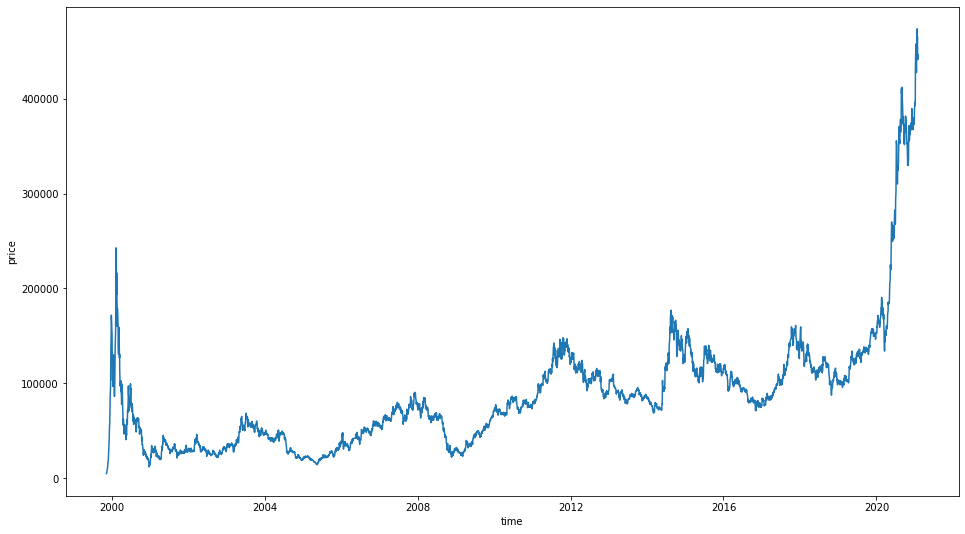

In [ ]:
#시각화
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

In [ ]:
# 데이터 전처리
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[1.03945720e-02, 1.03945720e-02, 1.08004338e-02, 0.00000000e+00,
        2.29796837e-06],
       [1.16012526e-02, 1.16012526e-02, 1.20542299e-02, 1.23366936e-03,
        2.68096309e-05],
       [1.29937370e-02, 1.29937370e-02, 1.35010846e-02, 2.65516380e-03,
        7.75564324e-05],
       ...,
       [9.60334029e-01, 9.61377871e-01, 9.45770065e-01, 9.30632778e-01,
        2.04919989e-01],
       [9.10229645e-01, 9.24843424e-01, 9.21908894e-01, 9.31699966e-01,
        1.74281942e-01],
       [9.39457203e-01, 9.54070981e-01, 9.62039046e-01, 9.41304659e-01,
        1.03271273e-01]])

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [ ]:
#train / test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)
x_train.shape, y_train.shape

((4192, 4), (4192,))

In [ ]:
x_test.shape, y_test.shape

((1048, 4), (1048,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.010395,0.010395,0.010800,0.000002
1,0.011601,0.011601,0.012054,0.000027
2,0.012994,0.012994,0.013501,0.000078
3,0.014524,0.014524,0.015091,0.000041
4,0.016242,0.016242,0.016876,0.000037
...,...,...,...,...
4187,0.170355,0.170564,0.174403,0.036816
4188,0.170564,0.170564,0.174620,0.028747
4189,0.167641,0.172651,0.174187,0.058442
4190,0.172025,0.172234,0.174403,0.036307


In [ ]:
#TensroFlow Dataset을 활용한 시퀀스 데이터셋
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
#Hyperparameter
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:

# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [ ]:
#모델링
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])


In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈추기.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
131/131 [==============================] - 4s 16ms/step - loss: 0.0012 - mse: 0.0024 - val_loss: 0.0015 - val_mse: 0.0030

Epoch 00001: val_loss improved from inf to 0.00149, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
131/131 [==============================] - 2s 11ms/step - loss: 1.7920e-04 - mse: 3.5841e-04 - val_loss: 0.0012 - val_mse: 0.0023

Epoch 00002: val_loss improved from 0.00149 to 0.00116, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
131/131 [==============================] - 2s 11ms/step - loss: 1.7707e-04 - mse: 3.5413e-04 - val_loss: 9.0341e-04 - val_mse: 0.0018

Epoch 00003: val_loss improved from 0.00116 to 0.00090, saving model to tmp/ckeckpointer.ckpt
Epoch 4/50
131/131 [==============================] - 2s 11ms/step - loss: 1.5453e-04 - mse: 3.0906e-04 - val_loss: 7.9564e-04 - val_mse: 0.0016

Epoch 00004: val_loss improved from 0.00090 to 0.00080, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
131/131 [==============================] - 2s 11m

In [ ]:
#저장한 ModelCheckpoint 를 로드
model.load_weights(filename)

In [ ]:
#test_data를 활용해서 예측
pred = model.predict(test_data)

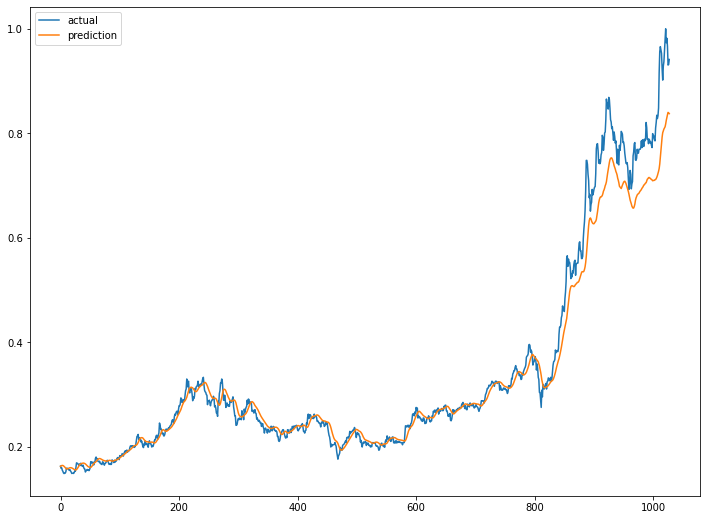

In [ ]:
#예측 데이터 시각화
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()